In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
import statsmodels.api as sm
import statsmodels.formula.api as smf
#from statsmodels.stats.outliers_influence import variance_inflation_factor
#import requests
import json
import time
from Ames_Functions import *
import pickle
pd.set_option("display.max_columns", None)

In [103]:
df_house2021 = pd.read_csv("df_RE_latlongs_v2_2021.csv", index_col = 0).set_index("SaleID")
df_house2019 = load_state_pkl()["df_RE_latlong2019"][0].set_index("SaleID")
df_biz = pd.read_csv("df_EssentialLatLong_v2.csv")
#df_min_distances = pd.read_csv("df_min_distances.csv", index_col = 0)
df_driv_time_final2019 = load_state_pkl()["2019dfs_for_feature_engineering"][0]["from_time"]

In [ ]:
# df_cross = df_house.join(df_biz, how = "cross", lsuffix = "_house", rsuffix = "_biz")
# df_cross

In [98]:
# df_cross["dist"] = df_cross.apply(lambda x: get_dist(np.array([x.Lat_house, x.Long_house]), np.array([x.Lat_biz, x.Long_biz])), axis = 1)
# #df_cross.to_csv("df_cross.csv")

## Finding differences in two different variables for feature engineering
## (SKIP)

In [439]:
# (df_driv_final["from_time"]
#     .eval("HS_Lib_diff = abs(High_School - Library)")
#     .eval("SV_Rest_diff = abs(Sports_Venue - Restaurant)")
#     .eval("Mov_Rest_diff = abs(Movies-Restaurant)")
#     .eval("Park_Rec_diff = abs(Park - Recreation)")
#     .eval("Groc_Shop_diff = abs(Organic_Groceries - Shopping)")
# ).filter(regex = "diff$").corr()
# #Possible ratios to consider:
# #High_School/Library
# #Sports_Venue/Restaurant
# #Movies/Restaurant
# #Park/Recreation
# #Organic_Groceries/Shopping
# #ISU/Library

,HS_Lib_diff,SV_Rest_diff,Mov_Rest_diff,Park_Rec_diff,Groc_Shop_diff
HS_Lib_diff,1.000000,-0.727417,-0.547363,-0.152308,-0.219560
SV_Rest_diff,-0.727417,1.000000,0.848838,-0.122952,0.397418
Mov_Rest_diff,-0.547363,0.848838,1.000000,-0.274410,0.370700
Park_Rec_diff,-0.152308,-0.122952,-0.274410,1.000000,-0.468057
Groc_Shop_diff,-0.219560,0.397418,0.370700,-0.468057,1.000000


## Finding ratios of distances from two different services for feature engineering 
## (SKIP)

In [652]:
#Possible ratios to consider:
#High_School/Library
#Sports_Venue/Restaurant
#Movies/Restaurant
#Park/Recreation
#Organic_Groceries/Shopping
#ISU/Library

ratio_dict = {}

for a, b in [("High_School", "Library"), ("Sports_Venue", "Restaurant"), ("Movies", "Restaurant"), ("Park", "Recreation"), ("Organic_Groceries", "Shopping"), ("ISU", "Library")]:
      ratio_dict[f"{a}_{b}_ratio"] = (df_driv_final["from_time"]
                                                .apply(lambda x: x[a]/x[b] if x[a] > x[b] else x[b]/x[a], axis = 1)
                                                .rename(f"{a}_{b}_ratio")
                                    )

pd.DataFrame(ratio_dict).join(df_driv_final["from_time"].SalePrice)

,High_School_Library_ratio,Sports_Venue_Restaurant_ratio,Movies_Restaurant_ratio,Park_Recreation_ratio,Organic_Groceries_Shopping_ratio,ISU_Library_ratio,SalePrice
SaleID,,,,,,,
2,1.201318,2.804738,2.791816,1.018666,1.573722,1.159183,78000.0
3,1.201318,2.804738,2.791816,1.018666,1.573722,1.159183,408905.0
18,1.197453,2.743412,2.730929,1.018309,1.553475,1.156232,434066.0
19,1.196223,2.724280,2.711934,1.018196,1.547170,1.155292,88000.0
20,1.194971,2.704985,2.692777,1.018080,1.540816,1.154335,88000.0
...,...,...,...,...,...,...,...
22743,1.736798,1.551261,1.102166,1.041003,1.440054,1.712640,220000.0
22749,1.682007,1.504043,1.092605,1.038153,1.401589,1.659646,217500.0
22756,1.650223,1.477176,1.087238,1.036486,1.379769,1.628904,229000.0


In [ ]:
EDA_report(pd.DataFrame(ratio_dict).drop(["Sports_Venue_Restaurant_ratio", "ISU_Library_ratio"], axis = 1).join(df_driv_final["from_time"].SalePrice))

In [665]:
get_vif(pd.DataFrame(ratio_dict).drop(["Sports_Venue_Restaurant_ratio", "ISU_Library_ratio"], axis = 1))

[2.6474191730790873,
 2.0026501116710853,
 2.9995764720823432,
 1.1216954870182765]

## Lasso feature selection section using lassoCV

### 2021 section

In [ ]:
#checking VIF for all df_driv_final variables
get_vif(df_driv_final["from_time"].iloc[:, :-1])

In [398]:
X_lassoCV = {}
y_lassoCV = {}
X_lassoCV["from_time"] = df_driv_final["from_time"].drop("SalePrice", axis = 1)
y_lassoCV["from_time"] = df_driv_final["from_time"].SalePrice

In [ ]:
lassoCV = LassoCV(normalize = True)
lassoCV.fit(X_lassoCV["from_time"], y_lassoCV["from_time"])
lassoCV.feature_names_in_[np.where(lassoCV.coef_ != 0)]

In [ ]:
#checking VIF for only the lassoCV selected features in df_driv_final
lassoCV_coefs = {}

lassoCV_coefs["from_time"] = df_driv_final["from_time"][lassoCV.feature_names_in_[np.where(lassoCV.coef_ != 0)]]
lassoCV_coefs["from_time"].corr()

#get_vif(lassoCV_coefs["from_time"])

,Lat_house,Movies,Park,Recreation,Spa
Lat_house,1.000000,0.574386,0.114682,0.045949,-0.037722
Movies,0.574386,1.000000,0.563701,0.699062,0.537828
Park,0.114682,0.563701,1.000000,0.541209,0.569881
Recreation,0.045949,0.699062,0.541209,1.000000,0.930184
Spa,-0.037722,0.537828,0.569881,0.930184,1.000000


### 2019 section

In [13]:
#checking VIF for all df_driv_final variables
get_vif(df_driv_time_final2019.iloc[:, 2:-1])

[497.8720803675777,
 166.25262248853497,
 105.49663127559329,
 47.42152644218676,
 165.93510868566523,
 736.8679303864168,
 541.2549557538485,
 474.8168538915485,
 775.8228970286154,
 567.6047378056903,
 74.83131469946107,
 133.6042345276011,
 163.16991644494607,
 47.907261158854055,
 171.76357040297557,
 432.41773327566807,
 243.22226438952976,
 1123.4555166356288]

In [15]:
X_lassoCV = {}
y_lassoCV = {}
X_lassoCV["from_time"] = df_driv_time_final2019.drop("SalePrice", axis = 1)
y_lassoCV["from_time"] = df_driv_time_final2019.SalePrice

In [16]:
lassoCV = LassoCV(normalize = True)
lassoCV.fit(X_lassoCV["from_time"], y_lassoCV["from_time"])
lassoCV.feature_names_in_[np.where(lassoCV.coef_ != 0)]

/Users/lelandmurrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


array(['Golf', 'Library', 'Movies', 'Recreation', 'Religion'],
      dtype=object)

In [17]:
#checking VIF for only the lassoCV selected features in df_driv_final
lassoCV_coefs = {}

lassoCV_coefs["from_time"] = df_driv_time_final2019[lassoCV.feature_names_in_[np.where(lassoCV.coef_ != 0)]]
lassoCV_coefs["from_time"].corr()

#get_vif(lassoCV_coefs["from_time"])

,Golf,Library,Movies,Recreation,Religion
Golf,1.000000,0.233646,0.275352,0.433672,0.505963
Library,0.233646,1.000000,0.791193,0.841805,0.652546
Movies,0.275352,0.791193,1.000000,0.679968,0.396524
Recreation,0.433672,0.841805,0.679968,1.000000,0.747969
Religion,0.505963,0.652546,0.396524,0.747969,1.000000


## Find Homes that had all businesses nearby vs all homes that had businesses far away
## (SKIP)

In [522]:
#TODO: ADD THIS TO A VISUAL ON AMES MAP

#mean_shop = np.mean(df_driv_final["from_time"][["Shopping"]])[0]
df_nearby = (df_driv_final["from_time"]
    .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)[df_driv_final["from_time"].drop(["Lat_house", "Long_house", "SalePrice"], axis = 1).transform(lambda x: x < x.mean())]
    .dropna()
    #.isnull()
    #.sum(axis = 0)
    #.sort_values(ascending = False)
) #.plot.hist(alpha = 0.3) #.corr()

df_far = (df_driv_final["from_time"]
    .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)[df_driv_final["from_time"].drop(["Lat_house", "Long_house", "SalePrice"], axis = 1).transform(lambda x: x > x.mean())]
    .dropna()
    #.isnull()
    #.sum(axis = 0)
    #.sort_values(ascending = False)
) #.plot.hist(alpha = 0.3) #.corr()
df_far.corr().Library #Library, Elem, 

Arts                 1.000000
Elem_School         -0.072957
Golf                -0.072957
Gym                  0.996288
High_School         -0.072957
Historic             0.212780
ISU                  0.324654
Library              1.000000
Medical             -0.000541
Movies               0.996659
Organic_Groceries   -0.072957
Park                 0.996659
Recreation           0.998420
Religion             1.000000
Restaurant          -0.072957
Shopping            -0.072957
Spa                  1.000000
Sports_Venue         0.996659
Name: Library, dtype: float64

In [525]:
get_vif(df_far[["Library", "Historic"]])

[94.77171340563096, 94.77171340563096]

## Creating feature for average distance of closest 5 services to each house record

### 2021 Section

In [613]:
df_closest = {}

for i in [1, 5, 10, 15]:
    df_closest[f"Closest_{i}"] = (df_driv_final["from_time"]
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
        .sort_values("driv_time")
        .groupby("SaleID")
        .head(i)
        .sort_values(["SaleID", "driv_time"])
        .groupby("SaleID")
        .driv_time
        .mean()
        #[["driv_time"]]
        #.mean().driv_time
    )

pd.DataFrame(df_closest)#.join(df_driv_final["from_time"].SalePrice)

,Closest_1,Closest_5,Closest_10,Closest_15
SaleID,,,,
2,85.5,210.28,324.33,403.220000
3,85.5,210.28,324.33,403.220000
18,95.3,220.08,334.13,413.020000
19,98.5,223.28,337.33,416.220000
20,101.8,226.58,340.63,419.520000
...,...,...,...,...
22743,276.6,295.28,333.13,363.680000
22749,305.2,323.88,361.73,392.280000
22756,324.0,342.68,380.53,411.080000


In [877]:
selected_features_dict = {}
selected_features_dict["Closest_5_feature"] = df_closest['Closest_5']

In [ ]:
#Checking EDA report for each closest 1,5,10,15 businesses to a home
for i in [1,5,10,15]:
    EDA_report(pd.DataFrame(df_closest)[[f"Closest_{i}"]].join(df_driv_final["from_time"].SalePrice))

### 2019 Section

In [24]:
df_closest = {}

for i in [1, 5, 10, 15]:
    df_closest[f"Closest_{i}"] = (df_driv_time_final2019
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
        .sort_values("driv_time")
        .groupby("SaleID")
        .head(i)
        .sort_values(["SaleID", "driv_time"])
        .groupby("SaleID")
        .driv_time
        .mean()
        #[["driv_time"]]
        #.mean().driv_time
    )

pd.DataFrame(df_closest).sort_values("Closest_1")#.join(df_driv_final["from_time"].SalePrice)

,Closest_1,Closest_5,Closest_10,Closest_15
SaleID,,,,
1419,6.3,130.28,187.84,228.200000
12929,7.8,339.40,404.03,450.320000
8324,8.4,55.84,80.44,136.620000
12927,8.4,339.52,404.03,450.200000
8342,12.8,57.86,79.48,136.573333
...,...,...,...,...
3906,371.0,455.70,501.02,547.180000
3867,371.1,455.80,501.12,547.280000
3920,378.0,462.70,508.02,554.180000


In [ ]:
selected_features_dict = {}
selected_features_dict["Closest_5_feature"] = df_closest['Closest_5']

,Closest_1,SalePrice
count,901.000000,901.000000
mean,156.280244,226669.041065
std,91.405029,109469.497483
min,6.300000,4350.000000
25%,81.500000,158855.000000
50%,125.500000,213000.000000
75%,227.400000,282240.000000
max,392.600000,771530.000000


Field correlation with SalePrice
SalePrice    1.00000
Closest_1    0.06571
Name: SalePrice, dtype: float64
------------------------------

Random Forest Feature Importances
        Name Importance
0  Closest_1        1.0
------------------------------

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.898
Date:                Tue, 04 Jul 2023   Prob (F-statistic):             0.0486
Time:                        13:30:32   Log-Likelihood:                -11731.
No. Observations:                 901   AIC:                         2.347e+04
Df Residuals:                     899   BIC:                         2.347e+04
Df Model:                           1                                         
Covariance Type:            nonrobus

,Closest_5,SalePrice
count,901.000000,901.000000
mean,230.535072,226669.041065
std,106.177163,109469.497483
min,36.920000,4350.000000
25%,137.080000,158855.000000
50%,213.460000,213000.000000
75%,326.120000,282240.000000
max,477.300000,771530.000000


Field correlation with SalePrice
SalePrice    1.000000
Closest_5    0.095059
Name: SalePrice, dtype: float64
------------------------------

Random Forest Feature Importances
        Name Importance
0  Closest_5        1.0
------------------------------

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.198
Date:                Tue, 04 Jul 2023   Prob (F-statistic):            0.00429
Time:                        13:30:32   Log-Likelihood:                -11729.
No. Observations:                 901   AIC:                         2.346e+04
Df Residuals:                     899   BIC:                         2.347e+04
Df Model:                           1                                         
Covariance Type:            nonrob

,Closest_10,SalePrice
count,901.000000,901.000000
mean,284.022575,226669.041065
std,116.475471,109469.497483
min,56.180000,4350.000000
25%,188.230000,158855.000000
50%,276.660000,213000.000000
75%,379.990000,282240.000000
max,533.470000,771530.000000


Field correlation with SalePrice
SalePrice     1.000000
Closest_10    0.157182
Name: SalePrice, dtype: float64
------------------------------

Random Forest Feature Importances
         Name Importance
0  Closest_10        1.0
------------------------------

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     22.77
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           2.13e-06
Time:                        13:30:32   Log-Likelihood:                -11721.
No. Observations:                 901   AIC:                         2.345e+04
Df Residuals:                     899   BIC:                         2.346e+04
Df Model:                           1                                         
Covariance Type:            no

,Closest_15,SalePrice
count,901.000000,901.000000
mean,332.961102,226669.041065
std,122.259921,109469.497483
min,110.820000,4350.000000
25%,230.566667,158855.000000
50%,330.193333,213000.000000
75%,431.000000,282240.000000
max,602.353333,771530.000000


Field correlation with SalePrice
SalePrice     1.00000
Closest_15    0.18906
Name: SalePrice, dtype: float64
------------------------------

Random Forest Feature Importances
         Name Importance
0  Closest_15        1.0
------------------------------

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     33.32
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           1.07e-08
Time:                        13:30:32   Log-Likelihood:                -11716.
No. Observations:                 901   AIC:                         2.344e+04
Df Residuals:                     899   BIC:                         2.345e+04
Df Model:                           1                                         
Covariance Type:            nonr

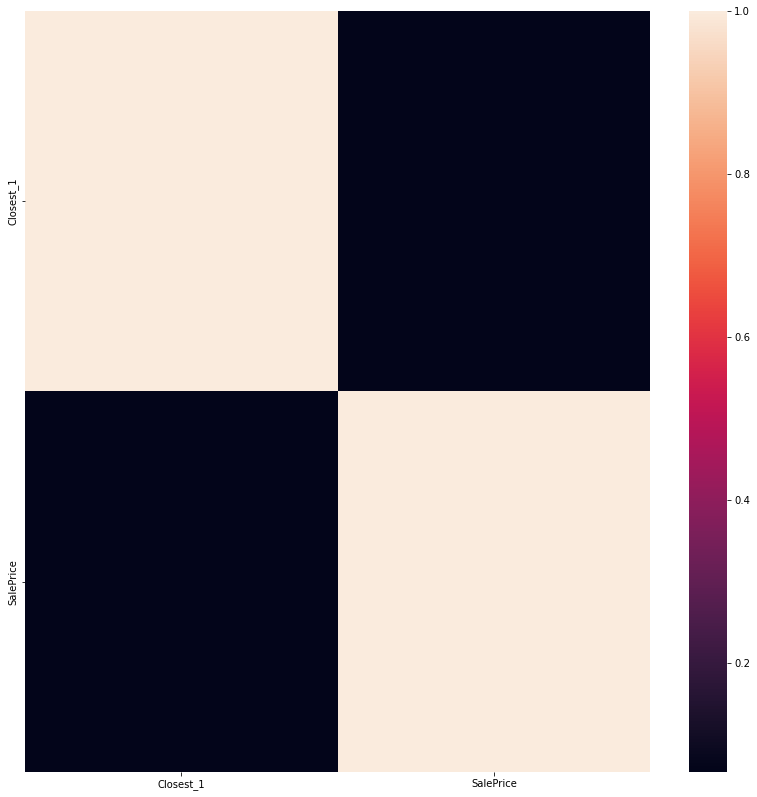

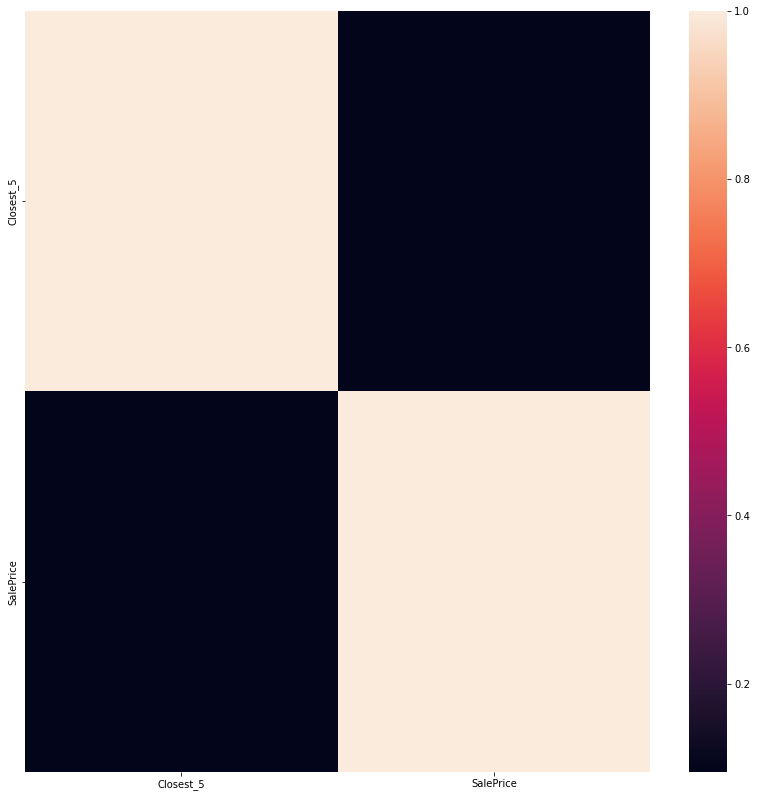

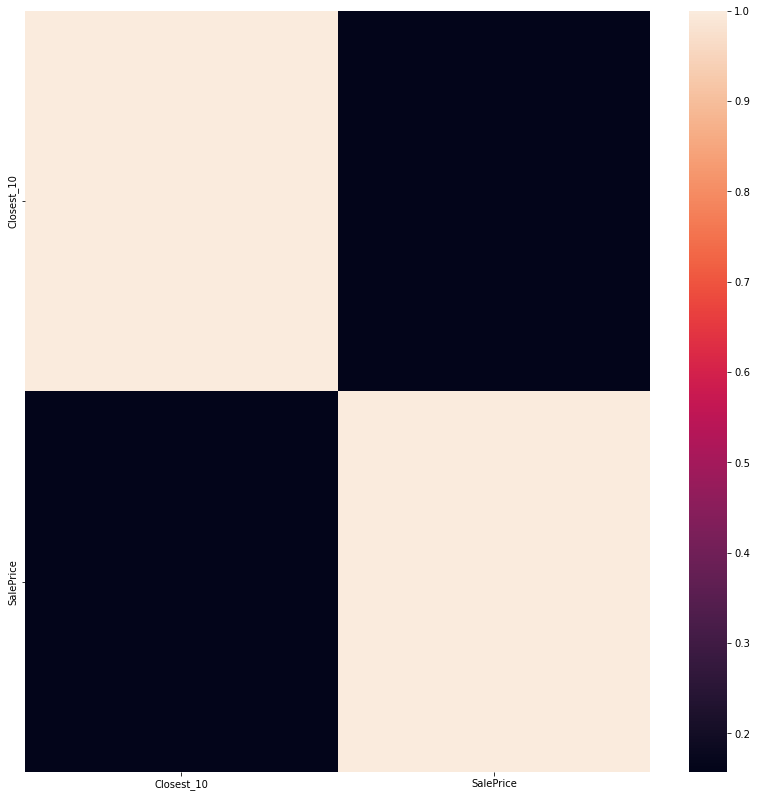

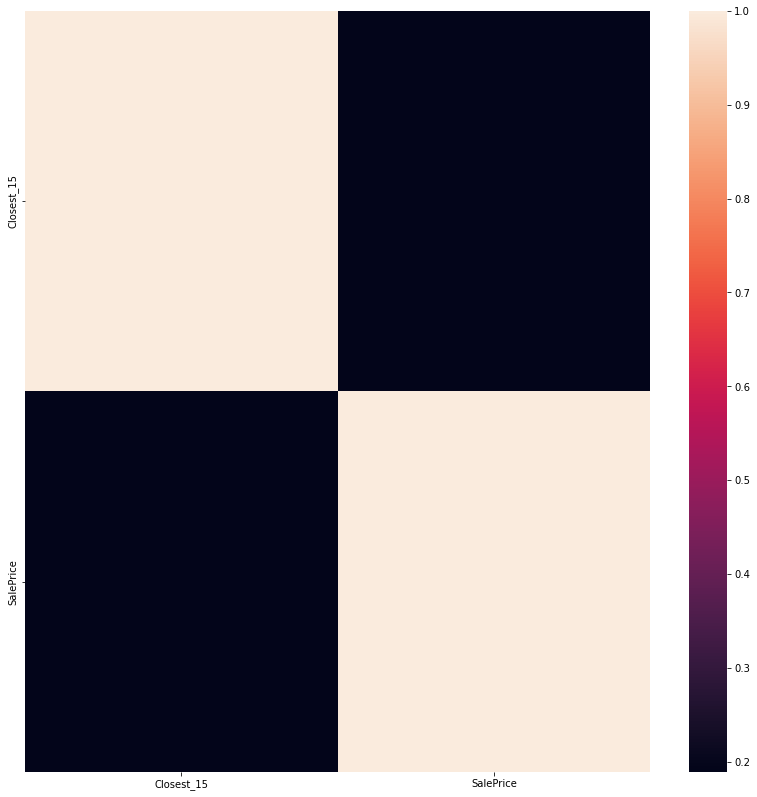

In [36]:
#Checking EDA report for each closest 1,5,10,15 businesses to a home
for i in [1,5,10,15]:
    EDA_report(pd.DataFrame(df_closest)[[f"Closest_{i}"]].join(df_driv_time_final2019.SalePrice))

## Convenience Measurement Section (average proximity to all closest services)

### 2021 Section

In [883]:
s_convenience = (df_driv_final["from_time"]
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
        .sort_values("driv_time")
        .groupby("SaleID")
        .driv_time
        .mean()
        .sort_values()
        .rename("Closest_all")
        # .groupby("SaleID")
        # .driv_time
        # .mean()
    )

pd.DataFrame(s_convenience).join(df_driv_final["from_time"].SalePrice)

,Closest_all,SalePrice
SaleID,,
9379,134.555556,199000.0
8302,137.072222,175500.0
9371,139.594444,205000.0
8227,143.994444,157500.0
9382,144.144444,175000.0
...,...,...
11354,618.622222,447000.0
11336,620.538889,358000.0
11334,621.338889,375000.0


,Closest_all,Closest_1,Closest_5,Closest_10,Closest_15,SalePrice
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,356.660102,146.818799,216.309131,269.608167,318.602665,258405.135861
std,118.338210,84.844802,99.695220,111.015770,116.822033,115168.322605
min,134.555556,1.300000,20.880000,47.680000,102.893333,900.000000
25%,250.172222,83.500000,136.700000,175.420000,213.113333,178000.000000
50%,360.616667,118.000000,201.840000,269.110000,318.920000,235000.000000
75%,447.522222,203.800000,297.360000,354.600000,405.180000,317000.000000
max,640.238889,371.800000,456.500000,533.470000,602.353333,793000.000000


Field correlation with SalePrice
SalePrice      1.000000
Closest_all    0.345661
Closest_15     0.332214
Closest_10     0.315230
Closest_5      0.262897
Closest_1      0.190147
Name: SalePrice, dtype: float64
------------------------------

Random Forest Feature Importances
          Name Importance
0  Closest_all   0.286193
3   Closest_10   0.205374
1    Closest_1    0.17517
2    Closest_5   0.170543
4   Closest_15   0.162719
------------------------------

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     25.70
Date:                Thu, 22 Jun 2023   Prob (F-statistic):           1.25e-23
Time:                        15:21:06   Log-Likelihood:                -8215.8
No. Observations:                 633   AIC:                   

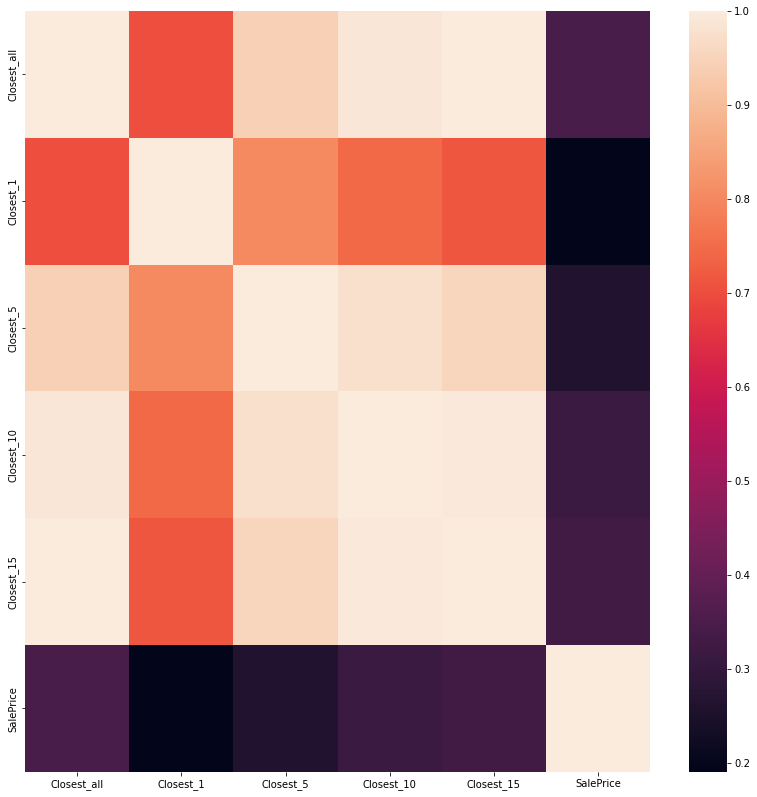

In [886]:
EDA_report(pd.DataFrame(s_convenience).join(pd.DataFrame(df_closest)).join(df_driv_final["from_time"].SalePrice))

In [890]:
get_vif(pd.DataFrame(df_central).join(pd.DataFrame(df_closest["Closest_1"].rename("Closest_1"))))

[7.650401862528, 7.650401862528]

In [899]:
selected_features_dict["Closest_all_feature"] = s_convenience
selected_features_dict

{'Closest_5_feature': SaleID
 2        210.28
 3        210.28
 18       220.08
 19       223.28
 20       226.58
           ...  
 22743    295.28
 22749    323.88
 22756    342.68
 22768    343.58
 22888    309.58
 Name: driv_time, Length: 633, dtype: float64,
 'Closest_all_feature': SaleID
 9379     134.555556
 8302     137.072222
 9371     139.594444
 8227     143.994444
 9382     144.144444
             ...    
 11354    618.622222
 11336    620.538889
 11334    621.338889
 11331    621.938889
 11368    640.238889
 Name: Closest_all, Length: 633, dtype: float64}

### 2019 Section

In [37]:
s_convenience = (df_driv_time_final2019
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
        .sort_values("driv_time")
        .groupby("SaleID")
        .driv_time
        .mean()
        .sort_values()
        .rename("Closest_all")
        # .groupby("SaleID")
        # .driv_time
        # .mean()
    )

pd.DataFrame(s_convenience).join(df_driv_time_final2019.SalePrice)

,Closest_all,SalePrice
SaleID,,
8229,144.972222,160000.0
8230,145.150000,158000.0
8427,147.944444,225000.0
8260,152.594444,200000.0
8291,153.816667,160000.0
...,...,...
11035,638.338889,289900.0
11266,638.938889,355284.0
11268,639.438889,328295.0


,Closest_all,Closest_1,Closest_5,Closest_10,Closest_15,SalePrice
count,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000
mean,370.669164,156.280244,230.535072,284.022575,332.961102,226669.041065
std,122.709903,91.405029,106.177163,116.475471,122.259921,109469.497483
min,144.972222,6.300000,36.920000,56.180000,110.820000,4350.000000
25%,268.266667,81.500000,137.080000,188.230000,230.566667,158855.000000
50%,373.433333,125.500000,213.460000,276.660000,330.193333,213000.000000
75%,462.655556,227.400000,326.120000,379.990000,431.000000,282240.000000
max,640.238889,392.600000,477.300000,533.470000,602.353333,771530.000000


Field correlation with SalePrice
SalePrice      1.000000
Closest_all    0.208342
Closest_15     0.189060
Closest_10     0.157182
Closest_5      0.095059
Closest_1      0.065710
Name: SalePrice, dtype: float64
------------------------------

Random Forest Feature Importances
          Name Importance
0  Closest_all   0.249009
4   Closest_15    0.21947
2    Closest_5   0.196649
3   Closest_10   0.179418
1    Closest_1   0.155455
------------------------------

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     42.46
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           2.63e-39
Time:                        13:37:33   Log-Likelihood:                -11637.
No. Observations:                 901   AIC:                   

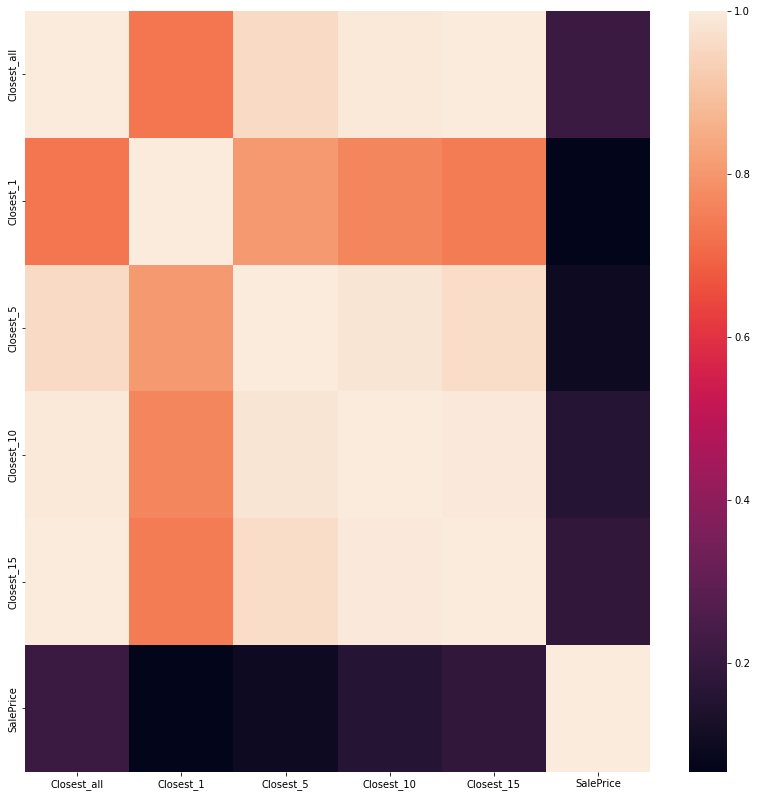

In [38]:
EDA_report(pd.DataFrame(s_convenience).join(pd.DataFrame(df_closest)).join(df_driv_time_final2019.SalePrice))

In [46]:
get_vif(pd.DataFrame(s_convenience).join(pd.DataFrame(df_closest["Closest_1"].rename("Closest_1"))))

[8.056200470406159, 8.056200470406166]

In [ ]:
selected_features_dict["Closest_all_feature"] = s_convenience
selected_features_dict

In [53]:
#Looking at which services are on average farthest away from all houses
#TODO: map this out
df_driv_time_final2019.iloc[:,2:-1].mean(axis = 0).sort_values(ascending = False)

Sports_Venue         541.872364
Movies               502.445061
High_School          452.219756
Historic             411.187791
Medical              410.176249
ISU                  409.526970
Park                 397.476249
Arts                 374.941287
Golf                 367.320977
Organic_Groceries    361.486016
Shopping             359.736071
Elem_School          331.709767
Library              330.651387
Restaurant           310.898002
Recreation           305.468036
Religion             285.614206
Spa                  276.918757
Gym                  242.396004
dtype: float64

## Centrality Measurement Section (Proximity to Historic Service which contains City Hall and Old Town Historic District)

In [910]:
selected_features_dict["Central_historic_feature"] = df_driv_final["from_time"].Historic

dict_keys(['Closest_5_feature', 'Closest_all_feature', 'Central_historic_feature'])

In [54]:
df_driv_time_final2019.Historic

SaleID
92       626.9
93       626.9
96       524.0
98       525.2
100      537.7
         ...  
22745    407.2
22747    408.2
22750    421.1
22755    437.7
22797    135.6
Name: Historic, Length: 901, dtype: float64

## Count Number of Businesses within 1 minute of each house section

### 2021 Section

In [913]:
num_biz_dict = {}

for i in np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])*60:
    num_biz_dict[f"biz_{i}_secs"] = (df_driv_final["from_time"]
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
        .groupby("SaleID")
        .driv_time
        .apply(lambda x: (x <= i).sum())
        .rename("count")
        #.where(lambda x: x <= i)
        # .query(f"driv_time <= {i}")
        # .SaleID
        # .value_counts()
        #.sort_values("driv_time")
        #.filter(lambda x: x.driv_time <= i)
        # .head(i)
        # .sort_values(["SaleID", "driv_time"])
        # .groupby("SaleID")
        # .driv_time
        # .mean()
    )

pd.DataFrame(num_biz_dict).join(df_driv_final["from_time"].SalePrice)

,biz_60_secs,biz_120_secs,biz_180_secs,biz_240_secs,biz_300_secs,biz_360_secs,biz_420_secs,biz_480_secs,biz_540_secs,biz_600_secs,SalePrice
SaleID,,,,,,,,,,,
2,0,1,2,2,5,6,6,8,12,13,78000.0
3,0,1,2,2,5,6,6,8,12,13,408905.0
18,0,1,2,2,5,6,6,8,12,13,434066.0
19,0,1,2,2,4,6,6,8,12,13,88000.0
20,0,1,2,2,4,6,6,8,12,13,88000.0
...,...,...,...,...,...,...,...,...,...,...,...
22743,0,0,0,0,3,7,13,15,15,16,220000.0
22749,0,0,0,0,0,5,10,14,15,16,217500.0
22756,0,0,0,0,0,4,7,14,15,15,229000.0


,biz_60_secs,biz_120_secs,biz_180_secs,biz_240_secs,biz_300_secs,biz_360_secs,biz_420_secs,biz_480_secs,biz_540_secs,biz_600_secs,SalePrice
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,0.206951,1.412322,3.227488,5.164297,7.393365,9.448657,11.562401,13.548183,15.096367,16.293839,258405.135861
std,0.799416,2.327391,3.645537,4.693942,5.416958,5.640409,5.230719,4.291731,3.212200,2.328057,115168.322605
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,6.000000,7.000000,900.000000
25%,0.000000,0.000000,0.000000,1.000000,2.000000,5.000000,7.000000,10.000000,13.000000,15.000000,178000.000000
50%,0.000000,1.000000,2.000000,4.000000,6.000000,9.000000,12.000000,15.000000,16.000000,17.000000,235000.000000
75%,0.000000,2.000000,5.000000,9.000000,13.000000,15.000000,17.000000,17.000000,18.000000,18.000000,317000.000000
max,6.000000,11.000000,13.000000,16.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,793000.000000


Field correlation with SalePrice
SalePrice       1.000000
biz_60_secs    -0.102844
biz_120_secs   -0.254867
biz_300_secs   -0.293965
biz_600_secs   -0.300373
biz_540_secs   -0.300436
biz_240_secs   -0.300663
biz_420_secs   -0.310708
biz_360_secs   -0.311504
biz_480_secs   -0.322112
biz_180_secs   -0.327461
Name: SalePrice, dtype: float64
------------------------------

Random Forest Feature Importances
           Name Importance
9  biz_600_secs   0.255216
6  biz_420_secs   0.116605
7  biz_480_secs   0.109098
4  biz_300_secs   0.101084
5  biz_360_secs   0.099381
3  biz_240_secs   0.095274
8  biz_540_secs   0.091157
2  biz_180_secs   0.073131
1  biz_120_secs   0.044686
0   biz_60_secs    0.01437
------------------------------

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Leas

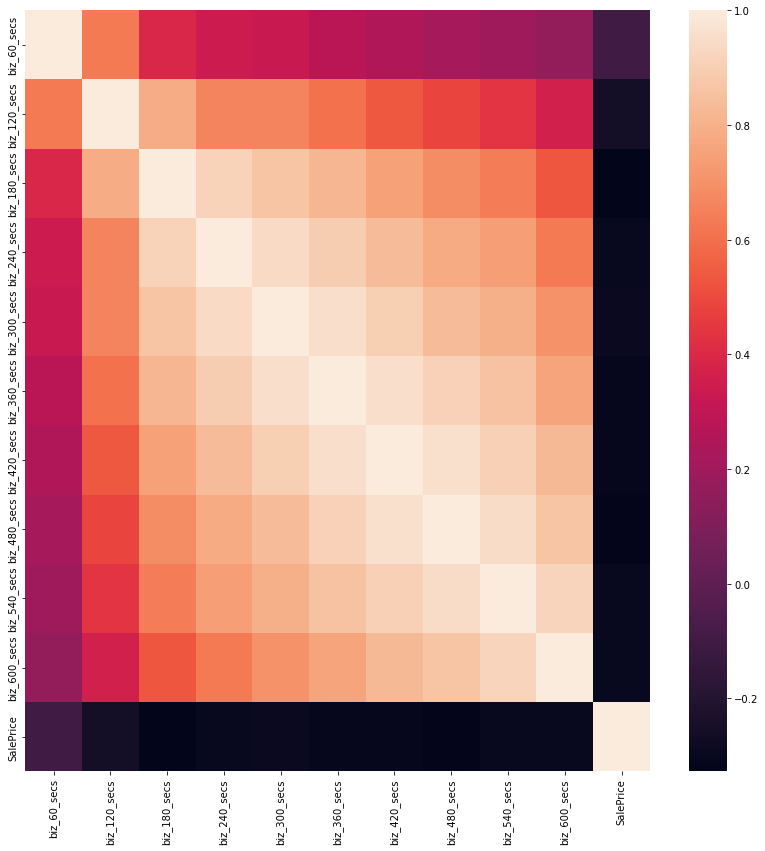

In [914]:
EDA_report(pd.DataFrame(num_biz_dict).join(df_driv_final["from_time"].SalePrice))

<AxesSubplot:ylabel='Frequency'>

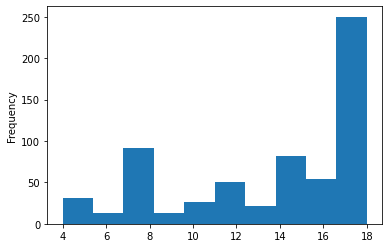

In [933]:
pd.DataFrame(num_biz_dict).biz_480_secs.plot.hist()

In [920]:
get_vif(pd.DataFrame(num_biz_dict)[["biz_180_secs", "biz_480_secs"]])

[2.6345201515612775, 2.6345201515612775]

In [935]:
selected_features_dict["num_biz_180s_feature"], selected_features_dict["num_biz_480s_feature"] = num_biz_dict["biz_180_secs"], num_biz_dict["biz_480_secs"]
selected_features_dict.keys()

dict_keys(['Closest_5_feature', 'Closest_all_feature', 'Central_historic_feature', 'num_biz_180s_feature', 'num_biz_480s_feature'])

In [740]:
#mean driving time in minutes for all businesses
df_driv_final["from_time"].drop(["Lat_house", "Long_house", "SalePrice"], axis = 1).describe().T['mean'].mean()/60

5.944335030132818

In [937]:
pickle.dump(selected_features_dict, open("selected_features_dict.pkl", 'wb'))

### 2019 Section

In [56]:
num_biz_dict = {}

for i in np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])*60:
    num_biz_dict[f"biz_{i}_secs"] = (df_driv_time_final2019
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
        .groupby("SaleID")
        .driv_time
        .apply(lambda x: (x <= i).sum())
        .rename("count")
        #.where(lambda x: x <= i)
        # .query(f"driv_time <= {i}")
        # .SaleID
        # .value_counts()
        #.sort_values("driv_time")
        #.filter(lambda x: x.driv_time <= i)
        # .head(i)
        # .sort_values(["SaleID", "driv_time"])
        # .groupby("SaleID")
        # .driv_time
        # .mean()
    )

pd.DataFrame(num_biz_dict).join(df_driv_time_final2019.SalePrice)

,biz_60_secs,biz_120_secs,biz_180_secs,biz_240_secs,biz_300_secs,biz_360_secs,biz_420_secs,biz_480_secs,biz_540_secs,biz_600_secs,SalePrice
SaleID,,,,,,,,,,,
92,0,0,0,0,0,2,4,6,10,11,125000.0
93,0,0,0,0,0,2,4,6,10,11,100000.0
96,0,0,0,0,1,3,7,8,14,15,399000.0
98,0,0,0,0,1,3,7,8,13,15,36000.0
100,0,0,0,0,1,2,7,8,11,15,36000.0
...,...,...,...,...,...,...,...,...,...,...,...
22745,0,0,0,0,2,5,12,14,15,16,175000.0
22747,0,0,0,0,2,5,11,14,15,16,137500.0
22750,0,0,0,0,0,5,9,14,15,16,200000.0


,biz_60_secs,biz_120_secs,biz_180_secs,biz_240_secs,biz_300_secs,biz_360_secs,biz_420_secs,biz_480_secs,biz_540_secs,biz_600_secs,SalePrice
count,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000
mean,0.152053,1.207547,2.940067,4.663707,6.815760,8.947836,11.028857,13.096559,14.706992,16.028857,226669.041065
std,0.563884,1.959078,3.576585,4.575430,5.343679,5.725435,5.478164,4.580951,3.540660,2.749798,109469.497483
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,6.000000,7.000000,4350.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000,7.000000,9.000000,13.000000,15.000000,158855.000000
50%,0.000000,0.000000,1.000000,4.000000,6.000000,9.000000,12.000000,15.000000,16.000000,17.000000,213000.000000
75%,0.000000,2.000000,5.000000,8.000000,12.000000,15.000000,16.000000,17.000000,18.000000,18.000000,282240.000000
max,7.000000,10.000000,13.000000,15.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,771530.000000


Field correlation with SalePrice
SalePrice       1.000000
biz_60_secs    -0.059856
biz_120_secs   -0.158726
biz_600_secs   -0.174093
biz_420_secs   -0.179369
biz_300_secs   -0.180327
biz_360_secs   -0.180975
biz_540_secs   -0.183971
biz_240_secs   -0.194656
biz_480_secs   -0.195366
biz_180_secs   -0.214206
Name: SalePrice, dtype: float64
------------------------------

Random Forest Feature Importances
           Name Importance
8  biz_540_secs    0.14415
9  biz_600_secs   0.141621
4  biz_300_secs   0.137551
7  biz_480_secs   0.126324
6  biz_420_secs   0.123603
5  biz_360_secs   0.106147
3  biz_240_secs    0.10084
2  biz_180_secs   0.059469
1  biz_120_secs   0.046406
0   biz_60_secs   0.013888
------------------------------

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Leas

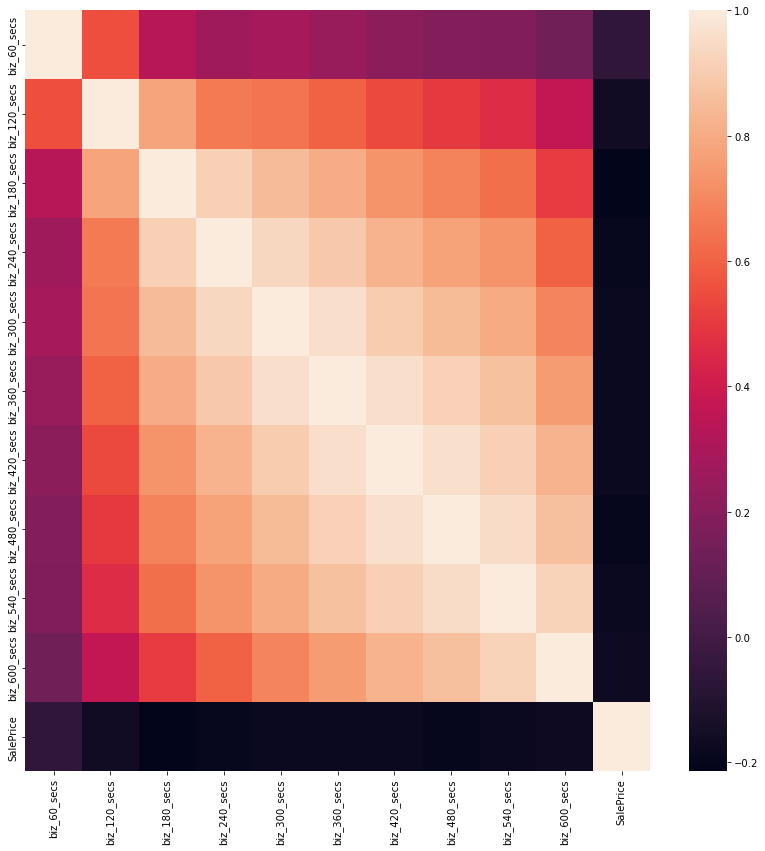

In [57]:
EDA_report(pd.DataFrame(num_biz_dict).join(df_driv_time_final2019.SalePrice))

<AxesSubplot:ylabel='Frequency'>

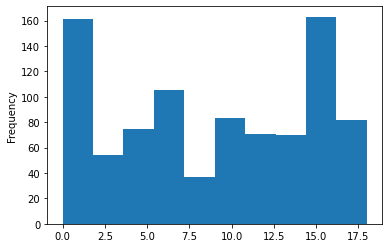

In [62]:
pd.DataFrame(num_biz_dict).biz_360_secs.plot.hist()

In [63]:
get_vif(pd.DataFrame(num_biz_dict)[["biz_180_secs", "biz_480_secs"]])

[2.493339804500264, 2.493339804500263]

In [ ]:
selected_features_dict["num_biz_180s_feature"], selected_features_dict["num_biz_480s_feature"] = num_biz_dict["biz_180_secs"], num_biz_dict["biz_480_secs"]
selected_features_dict.keys()

dict_keys(['Closest_5_feature', 'Closest_all_feature', 'Central_historic_feature', 'num_biz_180s_feature', 'num_biz_480s_feature'])

In [ ]:
#mean driving time in minutes for all businesses
df_driv_final["from_time"].drop(["Lat_house", "Long_house", "SalePrice"], axis = 1).describe().T['mean'].mean()/60

5.944335030132818

## Count the number of houses around each service

In [826]:
num_house_dict = {}

for s in np.array([2, 3, 4])*60:
    num_house_dict[f"house_{s}_secs"] = (df_driv_final["from_time"]
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time_secs"], axis = 1)
        .groupby('Service')
        .apply(lambda x: x[x.driv_time_secs < s].driv_time_secs.count())
    )

pd.DataFrame(num_house_dict).join(df_biz.Service.value_counts().rename("Service_count")).apply(lambda x: round(x/x.Service_count, 2), axis = 1).drop("Service_count", axis = 1)

,house_120_secs,house_180_secs,house_240_secs
Service,,,
Arts,17.67,43.00,64.33
Elem_School,23.50,49.50,111.00
Golf,1.33,16.33,33.00
Gym,27.25,52.75,81.00
High_School,2.00,28.00,110.00
Historic,29.00,58.00,80.50
ISU,0.00,3.00,64.00
Library,38.00,81.00,114.00
Medical,74.00,129.00,175.00


In [813]:
mean_SalePrice = {}

for s in np.array([2, 3, 4])*60:
    mean_SalePrice[f"mean_salePrice_{s}_secs"] = (df_driv_final["from_time"]
        .drop(["Lat_house", "Long_house"], axis = 1)
        .set_index("SalePrice")
        .stack()
        .reset_index()
        .set_axis(["SalePrice", "Service", "driv_time_secs"], axis = 1)
        .groupby('Service')
        .apply(lambda x: x[x.driv_time_secs < s].SalePrice.mean())
        .transform(round, ndigits = 2)
    )

pd.DataFrame(mean_SalePrice).sort_values(by = "mean_salePrice_120_secs")

,mean_salePrice_120_secs,mean_salePrice_180_secs,mean_salePrice_240_secs
Service,,,
High_School,147375.00,213282.14,206375.00
Historic,166041.12,184953.67,196863.83
Medical,178680.08,186369.58,200287.29
Recreation,184346.26,188721.04,202233.86
Spa,191721.71,208934.29,212455.78
Organic_Groceries,202259.42,212034.15,240566.40
Shopping,204111.48,200157.49,208839.61
Library,215477.43,204664.55,207509.27
Arts,218552.83,202680.42,213048.71


In [832]:
df_nearby_houses = (pd.DataFrame(mean_SalePrice)
    .join(pd.DataFrame(num_house_dict)
          .join(df_biz.Service.value_counts().rename("Service_count"))
          .apply(lambda x: round(x/x.Service_count, 2), axis = 1)
          .drop("Service_count", axis = 1))
    .sort_values('mean_salePrice_120_secs')
)

In [837]:
get_vif(df_nearby_houses.dropna()[["mean_salePrice_120_secs", "house_120_secs"]])

[1.697142040569102, 1.697142040569102]

In [820]:
df_biz.Service.value_counts().rename("Service_count")

Gym                  4
Religion             4
Recreation           4
Arts                 3
Golf                 3
Restaurant           3
Spa                  3
Park                 2
Shopping             2
Organic_Groceries    2
Elem_School          2
Library              2
Historic             2
Medical              1
ISU                  1
Sports_Venue         1
High_School          1
Movies               1
Name: Service_count, dtype: int64

## Real Estate Dataset Feature Engineering

Adding fields: TotalArea and TotalArea_Gar

In [ ]:
# df_house = df_house.eval("TotalArea = GLA + TtlBsmtSF	").eval("TotalArea_Gar = GLA + TtlBsmtSF	+ GarageArea")
# #df_RE_latlong.eval("TotalArea_Gar = GLA + TtlBsmtSF	+ GarageArea_RE", inplace = True)
# df_house#.filter(regex = "Area|SF|GLA")

Adding Fields "Has_Fireplace" and "Has_Garage" and "Has_Bsmt"

In [35]:
# has_feature = lambda x: 1 if x > 0 else 0

In [52]:
# df_house["Has_Fireplace"] = df_house.Fireplaces.apply(has_feature)

In [47]:
# df_house["Has_Garage"] = df_house.GarageArea.apply(has_feature)

In [46]:
# df_house["Has_Bsmt"] = df_house.TtlBsmtSF.apply(has_feature)

Adding Field TotalExt and dummy variables for it

In [114]:
# df_house2019.Ext1.unique().shape, df_house2019.Ext2.unique().shape, df_house2021.Ext1.unique().shape, df_house2021.Ext2.unique().shape

((13,), (16,), (12,), (14,))

In [80]:
# df_Ext_dummies = pd.get_dummies(df_house.Ext2).rename(columns = {"Brk Cmn": "BrkComm", "CmentBd": "CemntBd", "Wd Shng": "WdShing"})

# for col in df_house.Ext1.unique():
#     df_Ext_dummies[[col]] += pd.get_dummies(df_house.Ext1)[[col]]

# df_Ext_dummies.rename(columns = {"C'Block": "CBlock"})
# df_Ext_dummies.rename(columns = {col:col + "_Ext" for col in df_Ext_dummies.columns}, inplace = True)
# #(pd.get_dummies(df_house.Ext1)[["AsbShng"]] + pd.get_dummies(df_house.Ext2)[["AsbShng"]]).sum()

In [84]:
# df_house = df_house.join(df_Ext_dummies)

Adding dummy variable columns for GarageType and HouseStyle

In [100]:
# clean_colname = lambda x: x.replace("-", "_").replace(".", "_").replace("/", "_").replace(" ", "_")

In [ ]:
# df_house = df_house.join(pd.get_dummies(df_house.GarageType).rename(columns = {col:clean_colname(col) + "_GrType" for col in pd.get_dummies(df_house.GarageType).columns}))

In [98]:
# "2-h.5 /house".replace("-", "_").replace(".", "_").replace("/", "_").replace(" ", "_")

'2_h_5__house'

In [103]:
# df_house = df_house.join(pd.get_dummies(df_house.HouseStyle).rename(columns = {col:clean_colname(col) + "_HsStyle" for col in pd.get_dummies(df_house.HouseStyle).columns}))

In [104]:
# df_house.to_csv("df_RE_latlongs_v3.csv")

In [96]:
def transform_RE_features (df_input):
    df_RE = df_input.copy()

    # Adding Fields "Has_Fireplace" and "Has_Garage" and "Has_Bsmt"
    has_feature = lambda x: 1 if x > 0 else 0
    df_RE["Has_Fireplace"] = df_RE.Fireplaces.apply(has_feature)
    df_RE["Has_Garage"] = df_RE.GarageArea.apply(has_feature)
    df_RE["Has_Bsmt"] = df_RE.TtlBsmtSF.apply(has_feature)

    # Adding fields: TotalArea and TotalArea_Gar
    df_RE = df_RE.eval("TotalArea = GLA + TtlBsmtSF	").eval("TotalArea_Gar = GLA + TtlBsmtSF	+ GarageArea")
    
    # Adding Field TotalExt and dummy variables for it
    df_Ext_dummies = pd.get_dummies(df_RE.Ext2).rename(columns = {"Brk Cmn": "BrkComm", "CmentBd": "CemntBd", "Wd Shng": "WdShing"})

    for col in df_RE.Ext1.unique():
        df_Ext_dummies[[col]] += pd.get_dummies(df_RE.Ext1)[[col]]

    df_Ext_dummies.rename(columns = {"C'Block": "CBlock"}, inplace = True)
    df_Ext_dummies.rename(columns = {col:col + "_Ext" for col in df_Ext_dummies.columns}, inplace = True)
    df_RE = df_RE.join(df_Ext_dummies)

    # Adding dummy variable columns for GarageType
    clean_colname = lambda x: x.replace("-", "_").replace(".", "_").replace("/", "_").replace(" ", "_")
    df_RE = df_RE.join(pd.get_dummies(df_RE.GarageType).rename(columns = {col:clean_colname(col) + "_GrType" for col in pd.get_dummies(df_RE.GarageType).columns}))

    # Adding dummy variable columns for HouseStyle and renaming leading numbers with words
    df_RE = df_RE.join(pd.get_dummies(df_RE.HouseStyle).rename(columns = {col:clean_colname(col) + "_HsStyle" for col in pd.get_dummies(df_RE.HouseStyle).columns}))
    df_RE.rename(columns = {col: col.replace(" ", "_").replace("1", "One").replace("2", "Two").replace("5", "Five") for col in df_RE.columns}, inplace = True)

    return df_RE

In [107]:
save_state_pkl("df_house2021_after_feature_engineering",
                transform_RE_features(df_house2021), 
                "df_house2021 post feature engineering including boolean fields for Fireplace/Gar/Bsmt, dummy fields for Ext, GrType and HouseStyle, and TotalArea/TotalArea_Gar fields"
                )

save_state_pkl("df_house2019_after_feature_engineering",
                transform_RE_features(df_house2019),
                "df_house2019 post feature engineering including boolean fields for Fireplace/Gar/Bsmt, dummy fields for Ext, GrType and HouseStyle, and TotalArea/TotalArea_Gar fields"
                )

In [112]:
load_state_pkl()['df_house2021_after_feature_engineering'][0]

,MapRefNo,GeoRefNo,Tier,Range,Prop_Addr,ZngCdPr,ZngCdSc,ZngOLPr,ZngOLSc,ClassPr_S,ClassSc_S,Legal_Pr,SchD_S,TxD_S,MA_OwnrOne,MA_OwnrTwo,MA_LineOne,MA_LineTwo,MA_City,MA_State,MA_ZipOne,MA_ZipTwo,Rcrd_Yr,Rcrd_Mo,InstOne_No,InstOne_Yr,InstOne_Mo,InstOneTPr,LndAc_S,ImpAc_S,OthAc_S,TtlVal_AsrYr,ValType,XOneTPr_D,XOneTSc_D,XTwoTPr_D,XTwoTSc_D,XOneTPr_S,XOneTSc_S,XTwoTPr_S,XTwoTSc_S,LndAcXOneS,ImpAcXOneS,ImpAcXTwoS,HSTtl_D,MilVal_D,HSTtl_S,MilVal_S,AcreX_SOne,AcreGr,AcreNt_S,Neighborhood,LotArea,ParType,BldgNo_S,DwlgNo_S,BldgType,YrBuilt,HouseStyle,Foundation,RoofMatl,ExtOne,ExtTwo,MasVnrType,Heating,Central_Air,GLA,TtlBsmtSF,TotRmsAbvGrd,Fireplaces,PoolArea,GarageType,GarYrBlt,Cars,GarageArea,YrSold_YYYY,MoSold_MM,SalePrice,SaleType,SaleCond,ParclRel,PA-Nmbr,PA-PreD,PA-Strt,PA-StSfx,PA-PostD,PA-UnTyp,PA-UntNo,Date,Source,NmbrBRs,reverse_lookup_rd,Lat,Long,Has_Fireplace,Has_Garage,Has_Bsmt,TotalArea,TotalArea_Gar,AsbShng_Ext,BrkComm_Ext,BrkFace_Ext,CemntBd_Ext,HdBoard_Ext,ImStucc_Ext,MetalSd_Ext,No_Data_Ext,Plywood_Ext,Stone_Ext,Stucco_Ext,VinylSd_Ext,Wd_Sdng_Ext,WdShing_Ext,Two_Types_GrType,Attachd_GrType,Basment_GrType,BuiltIn_GrType,Carport_GrType,Detachd_GrType,No_Data_GrType,None_GrType,One_Story_HsStyle,One_Five_Fin_HsStyle,One_Five_Unf_HsStyle,Two_Story_HsStyle,Two_Five_Fin_HsStyle,Two_Five_Unf_HsStyle,No_Data_HsStyle,S_Foyer_HsStyle,S_Level_HsStyle
SaleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,5.204400e+08,520440010,0,0,4507 EVEREST AVE,FS-RL,NaN,NaN,NaN,RESIDENTIAL,VACANT LAND - IMPROVED OR UNIMPROVED,SCENIC VALLEY SD 4TH ADD LOT:16 \n AMES,5,45,GENESIS HOMES INC,NaN,750 SE ALICE'S RD,NaN,WAUKEE,IA,50263.0,NaN,2021.0,3.0,2021-02822,2021.0,3.0,WD,5700,0,0,5700,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0,0.0,NRidgHt,12493.0,Vac.Lot,0,0,No Data,0.0,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,0.0,0.0,0.0,0.0,0.0,No Data,0.0,0.0,0.0,2021.0,2.0,78000.0,WRDConv,Normal,Deed,4507.0,NaN,EVEREST,AVE,NaN,NaN,NaN,31-Mar-22,Ames City Assessor,0.0,Everest Avenue,42.064191,-93.662310,0,0,0,0.0,0.0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,5.204400e+08,520440020,0,0,4513 EVEREST AVE,FS-RL,NaN,NaN,NaN,RESIDENTIAL,1-STORY 1946 & NEWER ALL STYLES,SCENIC VALLEY SD 4TH ADD LOT:17 \n AMES,5,45,"YOUNGER, TOYIA KIANA",NaN,4513 EVEREST AVE,NaN,AMES,IA,50014.0,NaN,2021.0,7.0,2021-09126,2021.0,7.0,WD,96300,0,288800,385100,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0,0.0,NRidgHt,9595.0,Dwg&Lot,0,1,1FamDet,2020.0,1-Story,P'Conc,CompShg,VinylSd,VinylSd,Stone,GasFWA,Yes,1487.0,1487.0,7.0,1.0,0.0,Attachd,2020.0,3.0,641.0,2021.0,7.0,408905.0,NewSold,Partial,Deed,4513.0,NaN,EVEREST,AVE,NaN,NaN,NaN,31-Mar-22,Ames City Assessor,2.0,Everest Avenue,42.064191,-93.662310,1,1,1,2974.0,3615.0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
18,5.204500e+08,520450010,0,0,4421 EVEREST CIR,FS-RL,NaN,NaN,NaN,RESIDENTIAL,1-STORY 1946 & NEWER ALL STYLES,SCENIC VALLEY SD 4TH ADD LOT:15 \n AMES,5,45,"LOVIN, JAMES & DARCEY",NaN,4421 EVEREST CIR,NaN,AMES,IA,50010.0,NaN,2021.0,7.0,2021-08472,2021.0,7.0,WRDJSV,105600,0,316700,422300,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0,0.0,NRidgHt,13596.0,Dwg&Lot,0,1,1FamDet,2020.0,1-Story,P'Conc,CompShg,VinylSd,VinylSd,Stone,GasFWA,Yes,1545.0,1545.0,6.0,1.0,0.0,Attachd,2020.0,3.0,640.0,2021.0,6.0,434066.0,NewSold,Partial,Deed,4421.0,NaN,EVEREST,CIR,NaN,NaN,NaN,31-Mar-22,Ames City Assessor,3.0,6th Street,42.063979,-93.662658,1,1,1,3090.0,3730.0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
19,5.204500e+08,520450020,0,0,4415 EVEREST CIR,FS-RL,NaN,NaN,NaN,RESIDENTIAL,1-STORY 1946 & NEWER ALL STYLES,SCENIC VALLEY SD 4TH ADD LOT:14 \n AMES,5,45,HAPPE HOMES LLP,NaN,2575 N ANKENY BLVD STE 211,NaN,ANKENY,IA,50021.0,NaN,2021.0,4.0,2021-04915,2021.0,4.0,WD,102400,0,172000,274400,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0,0.0,NRidgHt,10890